In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

# Download dataset for Cats and Dogs from : https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765

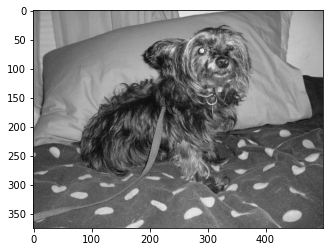

In [2]:
DATADIR = "E:\Coursework Repo\Kaggle\Datasets\PetImages"
CATEGORIES = ["Dog", "Cat"]

for category in CATEGORIES:
  path = os.path.join(DATADIR, category) # Add path to Cats and Dogs images directory
  for img in os.listdir(path):
    img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE) 
    # 3 times less info than RGB and color not needed to distinguish
    plt.imshow(img_array, cmap="gray")
    break
  break  

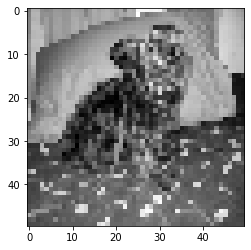

In [3]:
# All images in that dataset are variable in size, so we want to resize them to maintain consistency
IMG_SIZE = 50 
# Try changing this number until the image is sort of clear to us to distinguish
new_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE))
plt.imshow(new_array,cmap="gray")

In [4]:
training_data = []

def create_training_data():
    for category in CATEGORIES:
      path = os.path.join(DATADIR, category) # Add path to Cats and Dogs images directory
      # We should assign numbers to each output(Cat(1) and Dog(0))
      class_num = CATEGORIES.index(category)
      for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE) 
                new_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE))
                training_data.append([new_array, class_num])
            except Exception as e:
                pass
create_training_data()

In [5]:
print(len(training_data))
# Always ensure to get a balance on no. of images for each category. Here we aim for 50-50 training images for dog and cat

24946


In [6]:
# Now our training data list has Dogs first and then cats. This will screw with the predictions and hence we 
# shuffle the dataset passing it
import random

random.shuffle(training_data)

In [7]:
# Now pack the data into variables before feeding into the NN
X = [] #Feature Set
y = [] #Labels

for features, label in training_data:
    X.append(features)
    y.append(label)
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1) # Convert X into a numpy arr. -1 is random no, and 1 denotes grayscale
# The above step is just a default compulsory step to do before feeding into the NN

In [8]:
# Saving the model using pickle
# Can use np.save also:
# np.save('features.npy',X) #saving
# X=np.load('features.npy') #loading

import pickle

pickle_out = open("X.pickle", "wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle", "wb")
pickle.dump(y, pickle_out)
pickle_out.close()

In [9]:
# TO read the model in future:
pickle_in = open("X.pickle", "rb")
X = pickle.load(pickle_in)

In [10]:
X[1]

array([[[248],
        [248],
        [247],
        ...,
        [199],
        [199],
        [195]],

       [[246],
        [242],
        [245],
        ...,
        [201],
        [198],
        [194]],

       [[246],
        [242],
        [244],
        ...,
        [198],
        [195],
        [190]],

       ...,

       [[  4],
        [  4],
        [  5],
        ...,
        [ 31],
        [ 32],
        [ 36]],

       [[  6],
        [  4],
        [  4],
        ...,
        [ 33],
        [ 35],
        [ 34]],

       [[  3],
        [  4],
        [  4],
        ...,
        [ 32],
        [ 34],
        [ 36]]], dtype=uint8)

In [11]:
y[1] #Cat

0

In [17]:
# Feeding it into CNN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
# Use flatten before feeding data into the final dense layer
# We end the NN final layer as a dense fully connected layer (Dense)

import pickle

# To run multiple models in the GPU simultaneously
# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
# sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

X = pickle.load(open("X.pickle", "rb"))
y = pickle.load(open("y.pickle", "rb")) # Get features and labels data

# Normalize the data using keras.utils.Normalize but here we can just div by 255
X=np.array(X/255.0)
y=np.array(y)

model = Sequential()
# First we do convolution,then activation and then do maxPooling and the cycle continues
# This is the first hidden layer
model.add(Conv2D(64, (3,3), input_shape = X.shape[1:])) # The conv layer is 64 units
# 3,3 denotes the window side for Sliding window classifier (3x3 box)
model.add(Activation("relu")) # Relu is better than sigmoid function (Refer NG notes)
model.add(MaxPooling2D(pool_size=(2,2)))

#This is the 2nd hidden layer...obvio no need input shape
model.add(Conv2D(64, (3,3)))
model.add(Activation("relu")) # Relu is better than sigmoid function (Refer NG notes)
model.add(MaxPooling2D(pool_size=(2,2)))

# This is the final dense layer. Have to flatten from 2D convolution to 1D before entering dense state
model.add(Flatten())
model.add(Dense(64))
model.add(Activation("relu")) # TRY REMOVING IT, AND ALSO WITH SIGMOID AND FIND ACCURACY DIFF.

# Output layer
model.add(Dense(1)) # 0 for dog and 1 for cat toggle
model.add(Activation("sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy']) # Refer MNIST notebook

model.fit(X, y, batch_size = 32, epochs = 10, validation_split=0.1) # Inc. # of epochs to improve accuracy
# Use tf_gpu venv for faster computation than normal Tensorflow

Train on 22451 samples, validate on 2495 samples
Epoch 1/10
22451/22451 [==============================] - 6s 275us/sample - loss: 0.5933 - accuracy: 0.6791 - val_loss: 0.5486 - val_accuracy: 0.7291
Epoch 2/10
22451/22451 [==============================] - 5s 230us/sample - loss: 0.5005 - accuracy: 0.7571 - val_loss: 0.5227 - val_accuracy: 0.7307
Epoch 3/10
22451/22451 [==============================] - 5s 228us/sample - loss: 0.4588 - accuracy: 0.7856 - val_loss: 0.4949 - val_accuracy: 0.7647
Epoch 4/10
22451/22451 [==============================] - 5s 229us/sample - loss: 0.4186 - accuracy: 0.8097 - val_loss: 0.4482 - val_accuracy: 0.7940
Epoch 5/10
22451/22451 [==============================] - 5s 238us/sample - loss: 0.3838 - accuracy: 0.8242 - val_loss: 0.4568 - val_accuracy: 0.7892
Epoch 6/10
22451/22451 [==============================] - 5s 228us/sample - loss: 0.3448 - accuracy: 0.8458 - val_loss: 0.4437 - val_accuracy: 0.8028
Epoch 7/10
22451/22451 [===========================